In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip uninstall pandas scikit-learn -y
!pip install pandas scikit-learn

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 109.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [9]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=caba8cdfa2e53d67be968e39f5912906f5c904d591789b88d616a6781546c4c8
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


Using device: cuda

TRANSFORMER ENCODER FOR NER - PhoNER_COVID19
IMPROVED VERSION WITH FOCAL LOSS

📁 Loading data...
  ✓ Train samples: 5027
  ✓ Dev samples: 2000
  ✓ Test samples: 3000

📚 Building vocabularies...
  ✓ Vocabulary size: 3967
  ✓ Number of tags: 21

  Tag distribution:
    O                             : 129379 (77.22%)
    I-LOCATION                    :  12309 ( 7.35%)
    B-LOCATION                    :   5398 ( 3.22%)
    I-ORGANIZATION                :   4818 ( 2.88%)
    B-PATIENT_ID                  :   3240 ( 1.93%)
    B-DATE                        :   2549 ( 1.52%)
    I-DATE                        :   2500 ( 1.49%)
    I-SYMPTOM_AND_DISEASE         :   2270 ( 1.35%)
    B-SYMPTOM_AND_DISEASE         :   1439 ( 0.86%)
    B-ORGANIZATION                :   1137 ( 0.68%)
    B-AGE                         :    682 ( 0.41%)
    B-GENDER                      :    542 ( 0.32%)
    B-NAME                        :    349 ( 0.21%)
    I-JOB                         :    3

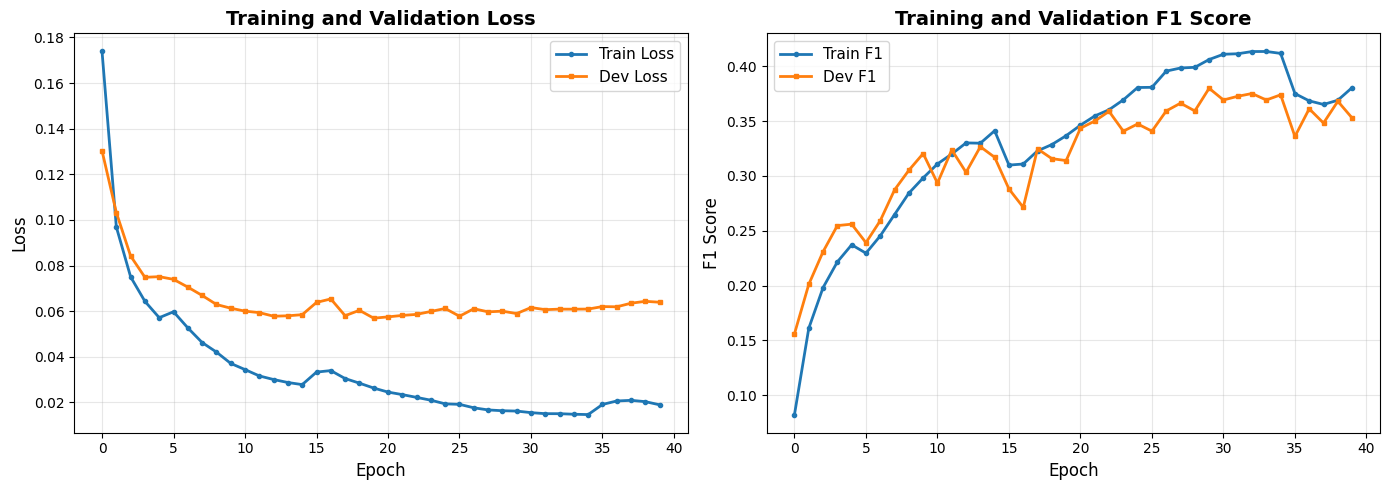

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
from collections import Counter
import math
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from seqeval.metrics import f1_score as seq_f1_score
from seqeval.metrics import classification_report as seq_classification_report
from seqeval.metrics import precision_score, recall_score

# ============== 1. POSITIONAL ENCODING ==============
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# ============== 2. MULTI-HEAD ATTENTION ==============
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def forward(self, x, mask=None):
        batch_size = x.size(0)

        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        attn_output, _ = self.scaled_dot_product_attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)
        return output

# ============== 3. FEED FORWARD NETWORK ==============
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

# ============== 4. ENCODER LAYER ==============
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# ============== 5. TRANSFORMER ENCODER FOR NER ==============
class TransformerNER(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, num_tags, max_len, dropout=0.1):
        super(TransformerNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

        # Add another dropout before classification
        self.classifier_dropout = nn.Dropout(dropout)

        # Token-level classification with additional layer
        self.fc1 = nn.Linear(d_model, d_model // 2)
        self.fc2 = nn.Linear(d_model // 2, num_tags)
        self.d_model = d_model

    def forward(self, x, mask=None):
        # x: (batch_size, seq_len)
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.encoder_layers:
            x = layer(x, mask)

        # Additional processing for better classification
        x = self.classifier_dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.classifier_dropout(x)
        logits = self.fc2(x)  # (batch_size, seq_len, num_tags)
        return logits

# ============== 6. DATASET ==============
class PhoNERDataset(Dataset):
    def __init__(self, data, word2idx, tag2idx, max_len):
        self.data = data
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        words = item['words']
        tags = item['tags']

        # Convert to indices
        word_ids = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]
        tag_ids = [self.tag2idx[tag] for tag in tags]

        # Get actual length before padding
        actual_len = len(word_ids)

        # Padding/Truncating
        if len(word_ids) < self.max_len:
            word_ids += [self.word2idx['<PAD>']] * (self.max_len - len(word_ids))
            tag_ids += [self.tag2idx['O']] * (self.max_len - len(tag_ids))
        else:
            word_ids = word_ids[:self.max_len]
            tag_ids = tag_ids[:self.max_len]
            actual_len = self.max_len

        return (torch.tensor(word_ids, dtype=torch.long),
                torch.tensor(tag_ids, dtype=torch.long),
                torch.tensor(actual_len, dtype=torch.long))

# ============== 7. LOAD DATA ==============
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                item = json.loads(line)
                data.append({
                    'words': item['words'],
                    'tags': item['tags']
                })
    return data

# ============== 8. BUILD VOCABULARY ==============
def build_vocab(train_data, min_freq=2):
    word_counts = Counter()
    for item in train_data:
        word_counts.update(item['words'])

    vocab = ['<PAD>', '<UNK>']
    vocab += [word for word, count in word_counts.items() if count >= min_freq]

    word2idx = {word: idx for idx, word in enumerate(vocab)}
    return word2idx, vocab

def build_tag_vocab(train_data):
    tags = set()
    for item in train_data:
        tags.update(item['tags'])

    tags = sorted(list(tags))
    tag2idx = {tag: idx for idx, tag in enumerate(tags)}
    idx2tag = {idx: tag for tag, idx in tag2idx.items()}
    return tag2idx, idx2tag

# ============== 9. FOCAL LOSS FOR IMBALANCED DATA ==============
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ============== 10. TRAIN FUNCTION ==============
def train_epoch(model, dataloader, criterion, optimizer, device, tag2idx):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for word_ids, tag_ids, lengths in dataloader:
        word_ids = word_ids.to(device)
        tag_ids = tag_ids.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        logits = model(word_ids)

        # Flatten for loss calculation
        logits_flat = logits.view(-1, logits.shape[-1])
        tags_flat = tag_ids.view(-1)

        loss = criterion(logits_flat, tags_flat)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

        # Get predictions for evaluation
        predictions = torch.argmax(logits, dim=-1)

        # Only consider non-padded tokens
        for i in range(len(lengths)):
            length = lengths[i].item()
            pred_tags = predictions[i, :length].cpu().numpy()
            true_tags = tag_ids[i, :length].cpu().numpy()
            all_preds.append(pred_tags)
            all_labels.append(true_tags)

    return total_loss / len(dataloader), all_preds, all_labels

# ============== 11. EVALUATE FUNCTION ==============
def evaluate(model, dataloader, criterion, device, idx2tag):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_pred_tags = []
    all_true_tags = []

    with torch.no_grad():
        for word_ids, tag_ids, lengths in dataloader:
            word_ids = word_ids.to(device)
            tag_ids = tag_ids.to(device)
            lengths = lengths.to(device)

            logits = model(word_ids)

            # Flatten for loss calculation
            logits_flat = logits.view(-1, logits.shape[-1])
            tags_flat = tag_ids.view(-1)

            loss = criterion(logits_flat, tags_flat)
            total_loss += loss.item()

            # Get predictions
            predictions = torch.argmax(logits, dim=-1)

            # Only consider non-padded tokens
            for i in range(len(lengths)):
                length = lengths[i].item()
                pred_tags = predictions[i, :length].cpu().numpy()
                true_tags = tag_ids[i, :length].cpu().numpy()
                all_preds.append(pred_tags)
                all_labels.append(true_tags)

                # Convert to tag strings for seqeval
                pred_tag_seq = [idx2tag[idx] for idx in pred_tags]
                true_tag_seq = [idx2tag[idx] for idx in true_tags]
                all_pred_tags.append(pred_tag_seq)
                all_true_tags.append(true_tag_seq)

    # Calculate metrics using seqeval
    f1 = seq_f1_score(all_true_tags, all_pred_tags)
    precision = precision_score(all_true_tags, all_pred_tags)
    recall = recall_score(all_true_tags, all_pred_tags)

    return total_loss / len(dataloader), f1, precision, recall, all_pred_tags, all_true_tags

# ============== 12. MAIN TRAINING ==============
def main():
    # Hyperparameters - OPTIMIZED
    d_model = 256
    num_heads = 8
    d_ff = 1024
    num_layers = 3
    max_len = 150
    batch_size = 16
    num_epochs = 50
    learning_rate = 0.0003  # Increased
    dropout = 0.3  # Increased for regularization
    min_freq = 1  # Lower threshold to keep more words

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print(f"\n{'='*60}")
    print("TRANSFORMER ENCODER FOR NER - PhoNER_COVID19")
    print("IMPROVED VERSION WITH FOCAL LOSS")
    print(f"{'='*60}\n")

    # Load data
    print("📁 Loading data...")
    train_data = load_data('/content/drive/MyDrive/DATASET/PhoNER-COVID19/train_syllable.json')
    dev_data = load_data('/content/drive/MyDrive/DATASET/PhoNER-COVID19/dev_syllable.json')
    test_data = load_data('/content/drive/MyDrive/DATASET/PhoNER-COVID19/test_syllable.json')

    print(f"  ✓ Train samples: {len(train_data)}")
    print(f"  ✓ Dev samples: {len(dev_data)}")
    print(f"  ✓ Test samples: {len(test_data)}")

    # Build vocabularies
    print("\n📚 Building vocabularies...")
    word2idx, vocab = build_vocab(train_data, min_freq=min_freq)
    tag2idx, idx2tag = build_tag_vocab(train_data)

    vocab_size = len(vocab)
    num_tags = len(tag2idx)

    print(f"  ✓ Vocabulary size: {vocab_size}")
    print(f"  ✓ Number of tags: {num_tags}")

    # Analyze tag distribution
    tag_counts = Counter()
    for item in train_data:
        tag_counts.update(item['tags'])

    print(f"\n  Tag distribution:")
    for tag, count in sorted(tag_counts.items(), key=lambda x: x[1], reverse=True):
        pct = count / sum(tag_counts.values()) * 100
        print(f"    {tag:30s}: {count:6d} ({pct:5.2f}%)")

    # Create datasets
    print("\n🔧 Creating datasets...")
    train_dataset = PhoNERDataset(train_data, word2idx, tag2idx, max_len)
    dev_dataset = PhoNERDataset(dev_data, word2idx, tag2idx, max_len)
    test_dataset = PhoNERDataset(test_data, word2idx, tag2idx, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    print("\n🚀 Initializing Transformer Encoder model...")
    print(f"  ✓ d_model: {d_model}")
    print(f"  ✓ num_heads: {num_heads}")
    print(f"  ✓ d_ff: {d_ff}")
    print(f"  ✓ num_layers: {num_layers}")
    print(f"  ✓ dropout: {dropout}")

    model = TransformerNER(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        num_layers=num_layers,
        num_tags=num_tags,
        max_len=max_len,
        dropout=dropout
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  ✓ Total parameters: {total_params:,}")
    print(f"  ✓ Trainable parameters: {trainable_params:,}")

    # Calculate class weights using inverse frequency
    total_tags = sum(tag_counts.values())
    class_weights = []
    for i in range(num_tags):
        tag = idx2tag[i]
        count = tag_counts[tag]
        # Square root of inverse frequency for smoother weights
        weight = math.sqrt(total_tags / (num_tags * count)) if count > 0 else 1.0
        class_weights.append(weight)

    class_weights = torch.FloatTensor(class_weights).to(device)

    # Use Focal Loss for better handling of class imbalance
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

    # Cosine annealing with warm restarts
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

    # Training loop
    print(f"\n{'='*60}")
    print("TRAINING")
    print(f"{'='*60}\n")

    train_losses, dev_losses = [], []
    train_f1s, dev_f1s = [], []
    best_dev_f1 = 0
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # Training
        train_loss, train_preds, train_labels = train_epoch(
            model, train_loader, criterion, optimizer, device, tag2idx
        )

        # Calculate train F1
        train_pred_tags = []
        train_true_tags = []
        for preds, labels in zip(train_preds, train_labels):
            train_pred_tags.append([idx2tag[idx] for idx in preds])
            train_true_tags.append([idx2tag[idx] for idx in labels])
        train_f1 = seq_f1_score(train_true_tags, train_pred_tags)

        # Validation
        dev_loss, dev_f1, dev_precision, dev_recall, _, _ = evaluate(
            model, dev_loader, criterion, device, idx2tag
        )

        train_losses.append(train_loss)
        dev_losses.append(dev_loss)
        train_f1s.append(train_f1)
        dev_f1s.append(dev_f1)

        print(f"  Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
        print(f"  Dev Loss:   {dev_loss:.4f} | Dev F1:   {dev_f1:.4f}")
        print(f"  Dev Precision: {dev_precision:.4f} | Dev Recall: {dev_recall:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Learning rate scheduling
        scheduler.step()

        # Save best model
        if dev_f1 > best_dev_f1:
            best_dev_f1 = dev_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'dev_f1': dev_f1,
                'word2idx': word2idx,
                'tag2idx': tag2idx,
                'idx2tag': idx2tag
            }, 'best_ner_model_improved.pt')
            print(f"  ✓ Best model saved! (F1: {best_dev_f1:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
                break

        print()

    # Load best model and evaluate on test set
    print(f"\n{'='*60}")
    print("TEST SET EVALUATION")
    print(f"{'='*60}\n")

    checkpoint = torch.load('best_ner_model_improved.pt', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_f1, test_precision, test_recall, test_preds, test_labels = evaluate(
        model, test_loader, criterion, device, idx2tag
    )

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    print(f"\n{'='*60}")
    print("DETAILED CLASSIFICATION REPORT")
    print(f"{'='*60}\n")
    print(seq_classification_report(test_labels, test_preds, digits=4))

    # Plot training curves
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o', markersize=3, linewidth=2)
    plt.plot(dev_losses, label='Dev Loss', marker='s', markersize=3, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1', marker='o', markersize=3, linewidth=2)
    plt.plot(dev_f1s, label='Dev F1', marker='s', markersize=3, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Training and Validation F1 Score', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ner_training_curves_improved.png', dpi=150, bbox_inches='tight')
    print("\n📊 Training curves saved to 'ner_training_curves_improved.png'")

    # Example predictions with words
    print(f"\n{'='*60}")
    print("EXAMPLE PREDICTIONS")
    print(f"{'='*60}\n")

    # Get some examples from test data
    num_examples = min(3, len(test_data))
    for i in range(num_examples):
        words = test_data[i]['words'][:20]
        true_tags = test_labels[i][:20]
        pred_tags = test_preds[i][:20]

        print(f"Example {i+1}:")
        print(f"  Words: {' '.join(words)}")
        print(f"  True:  {' '.join(true_tags)}")
        print(f"  Pred:  {' '.join(pred_tags)}")
        print()

    print(f"{'='*60}")
    print("✅ TRAINING COMPLETED!")
    print(f"{'='*60}\n")

if __name__ == "__main__":
    main()